In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import SelectKBest

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Data Dictionary.csv
/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Dataset.csv


In [2]:
# Using vaex to pre-process the large datasets
import vaex

In [3]:
df = pd.read_csv('/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [4]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [5]:
df.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [6]:
df['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [7]:
df[df['hospital_death'].isna()]

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem


In [8]:
df.isnull().sum()[df.isnull().sum() != 0]

age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 175, dtype: int64

In [9]:
# loading dataframe using vaex
ndf = vaex.from_csv_arrow('/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Dataset.csv')
ndf.info()

column,type,unit,description,expression
encounter_id,int64,,,
patient_id,int64,,,
hospital_id,int64,,,
hospital_death,int64,,,
age,int64,,,
bmi,float64,,,
elective_surgery,int64,,,
ethnicity,str,,,
gender,str,,,
height,float64,,,


- Filtering subdataset to select key columns
- Remove vitamins columns to reduce dataset

In [10]:
kdf = df.iloc[:,:19]
kdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   encounter_id           91713 non-null  int64  
 1   patient_id             91713 non-null  int64  
 2   hospital_id            91713 non-null  int64  
 3   hospital_death         91713 non-null  int64  
 4   age                    87485 non-null  float64
 5   bmi                    88284 non-null  float64
 6   elective_surgery       91713 non-null  int64  
 7   ethnicity              90318 non-null  object 
 8   gender                 91688 non-null  object 
 9   height                 90379 non-null  float64
 10  hospital_admit_source  70304 non-null  object 
 11  icu_admit_source       91601 non-null  object 
 12  icu_id                 91713 non-null  int64  
 13  icu_stay_type          91713 non-null  object 
 14  icu_type               91713 non-null  object 
 15  pr

In [11]:
fdf = pd.concat([kdf, df[['aids','diabetes_mellitus']]], axis=1)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   encounter_id           91713 non-null  int64  
 1   patient_id             91713 non-null  int64  
 2   hospital_id            91713 non-null  int64  
 3   hospital_death         91713 non-null  int64  
 4   age                    87485 non-null  float64
 5   bmi                    88284 non-null  float64
 6   elective_surgery       91713 non-null  int64  
 7   ethnicity              90318 non-null  object 
 8   gender                 91688 non-null  object 
 9   height                 90379 non-null  float64
 10  hospital_admit_source  70304 non-null  object 
 11  icu_admit_source       91601 non-null  object 
 12  icu_id                 91713 non-null  int64  
 13  icu_stay_type          91713 non-null  object 
 14  icu_type               91713 non-null  object 
 15  pr

- Removing redundant columns from the dataset

In [12]:
mdf = fdf.drop(['encounter_id','patient_id','readmission_status'], axis=1)
target = fdf['hospital_death']

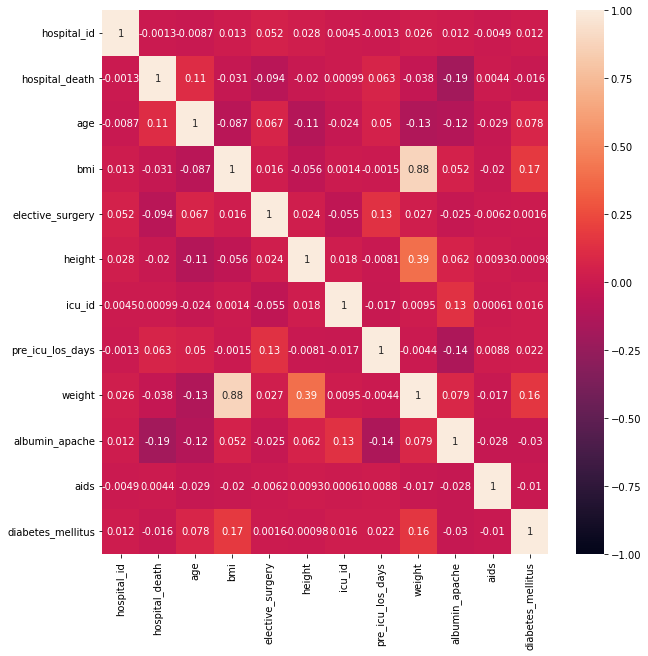

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(mdf.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

## Handling missing values

In [14]:
# let's check the albumin missing values
mdf['albumin_apache'].isnull().sum()/len(mdf['albumin_apache'])

0.5929257575261958

In [15]:
mdf['age']= mdf['age'].fillna(mdf['age'].mean())
mdf['bmi']= mdf['bmi'].fillna(mdf['bmi'].mean())
mdf['height']= mdf['height'].fillna(mdf['height'].mean())
mdf['weight'].fillna(mdf['weight'].mean(), inplace=True)

In [16]:
# handling missing values by most recurring values
mdf['hospital_admit_source'].replace(np.nan, 'Emergency Department', inplace=True)
mdf['icu_admit_source'].replace(np.nan,'Accident & Emergency', inplace=True)
mdf.drop('albumin_apache', axis=1, inplace=True)

In [17]:
# drop all the rows with missing values 
mdf.dropna(inplace=True, axis=0)
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89596 entries, 0 to 91712
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hospital_id            89596 non-null  int64  
 1   hospital_death         89596 non-null  int64  
 2   age                    89596 non-null  float64
 3   bmi                    89596 non-null  float64
 4   elective_surgery       89596 non-null  int64  
 5   ethnicity              89596 non-null  object 
 6   gender                 89596 non-null  object 
 7   height                 89596 non-null  float64
 8   hospital_admit_source  89596 non-null  object 
 9   icu_admit_source       89596 non-null  object 
 10  icu_id                 89596 non-null  int64  
 11  icu_stay_type          89596 non-null  object 
 12  icu_type               89596 non-null  object 
 13  pre_icu_los_days       89596 non-null  float64
 14  weight                 89596 non-null  float64
 15  ai

## EDA

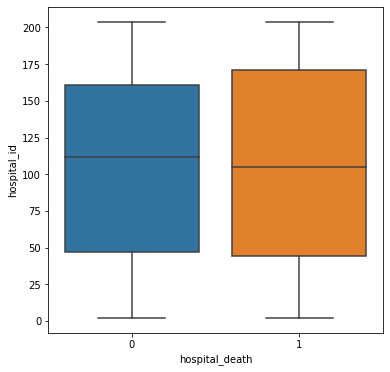

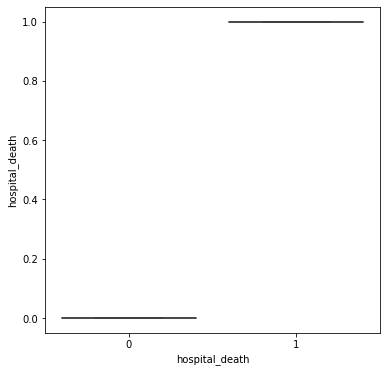

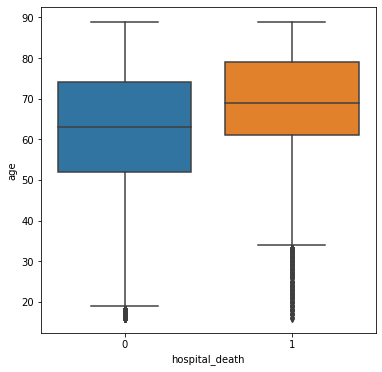

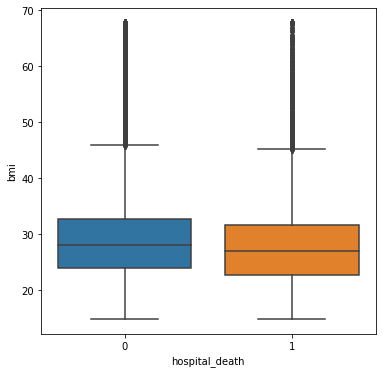

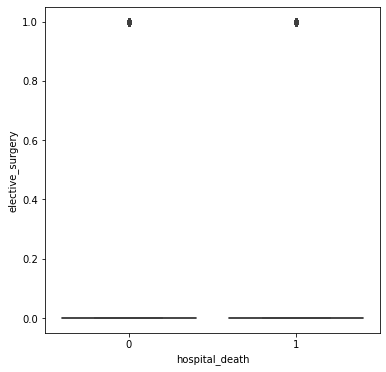

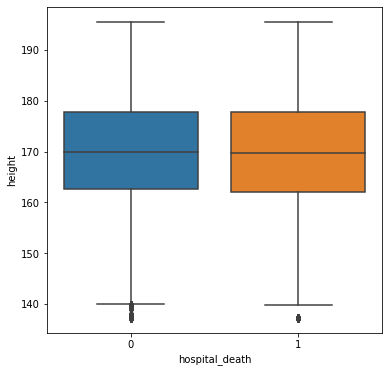

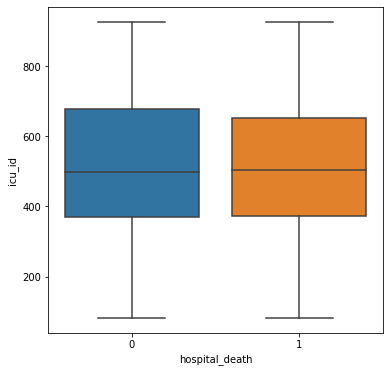

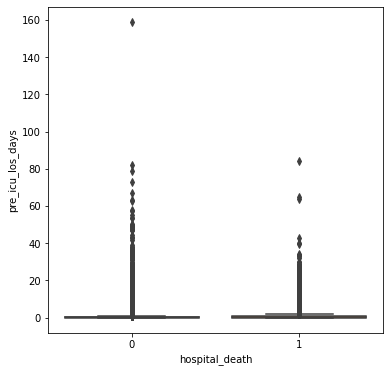

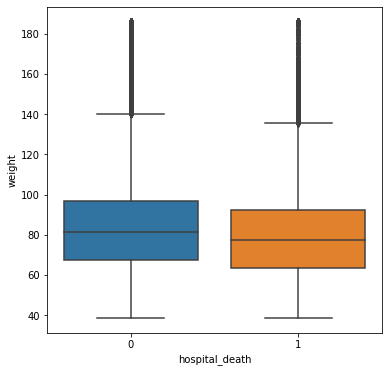

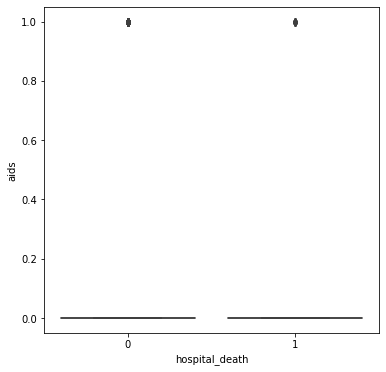

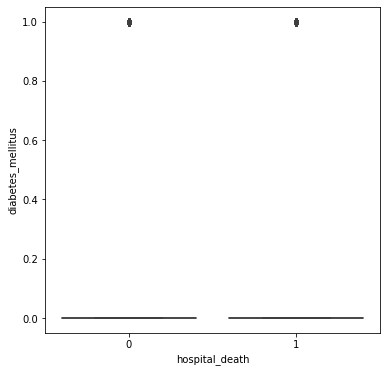

In [18]:
for i, col in enumerate(list(mdf.dtypes[mdf.dtypes != 'object'].index)):
    plt.figure(figsize=(6,6))
    sns.boxplot(x='hospital_death', y=col, data=mdf)
    plt.show()

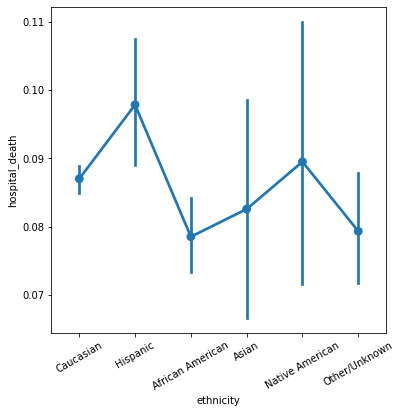

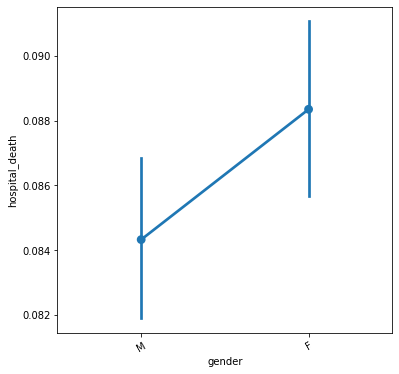

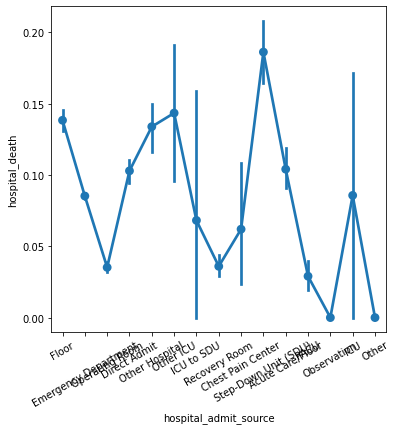

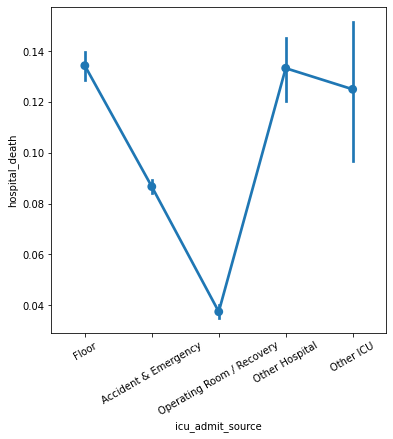

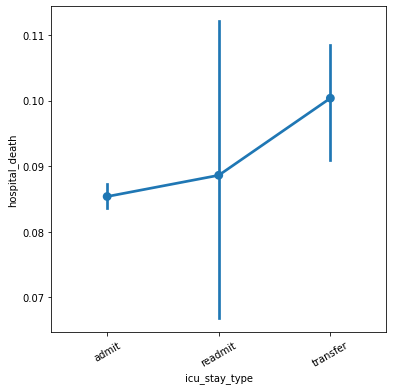

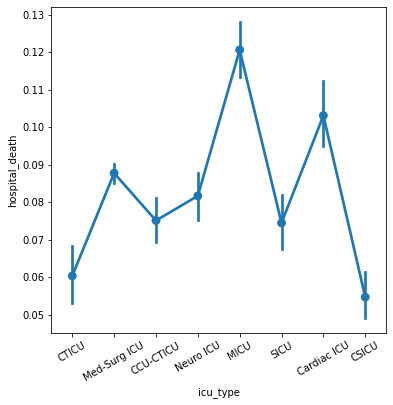

In [19]:
for col in list(mdf.dtypes[mdf.dtypes == 'object'].index):
    plt.figure(figsize=(6,6))
    sns.pointplot(y='hospital_death', x=col, data=mdf)
    plt.xticks(rotation=30)
    plt.show()

### Conclusions:

- Numerical columns are not indicative of target columns
- Categorical columns represent target variable more than numerical columns

### Next steps:

- Feature encoding
- Imbalance data treatment
- Select KBest features
- Feature scaling/transformation 
- NN modeling